# GEMS daymet-v4r1 Tutorial

### Section 1: Establish connection and explore available data

In [1]:
# Imports used in this notebook
from requests import Session

import pandas as pd
import rasterio
import numpy as np
from matplotlib import pyplot as plt

# Import your API key from a file
import sys
sys.path.append('..')
from api_key import key

# Establish connection
s = Session()
api_url = 'https://exchange-1.gems.msi.umn.edu/climate/v2/daymet-v4r1'
s.headers.update({'apikey': key})

# Define bounding box by string of "upper left lon, lat, bottom right lon, lat" in decimal degrees, no spaces
bbox = '-93.447444,48.65009,-88.83762,45.17553'

# Sample AOI of the upper midwest
aoi = {"type": "Polygon", "coordinates":
     [[[-90.86257188625456, 46.88471631149375],
       [-90.21090204846868, 47.84867191684921],
       [-90.13229204839561, 47.986461643867216],
       [-91.31830244956424, 47.81423854488315],
       [-91.43583296326011, 47.408369403885246],
       [-92.38327281856216, 46.879798020360425],
       [-91.9971011307051, 46.54594590211718],
       [-90.86257188625456, 46.88471631149375]]]}

In [2]:
# List available variables

res = s.get(f'{api_url}/layer')
variables = pd.json_normalize(res.json())
display(variables)

,name,units,description,discrete,id
0,Snow water equivalent,kilograms per square meter,Snow water equivalent in kilograms per square ...,False,20
1,Maximum air temperature,degrees C,Daily maximum 2 m air temperature in degrees C...,False,21
2,Minimum air temperature,degrees C,Daily minimum 2 m air temperature in degrees C...,False,22
3,Precipitation,millimeters,Daily total precipitation in millimeters. Sum ...,False,24
4,Shortwave radiation,watts per square meter,Incident shortwave radiation flux density in w...,False,26
5,Water vapor pressure,pascals,Water vapor pressure in pascals. Daily average...,False,29
6,Day length,seconds per day,Duration of the daylight period in seconds per...,False,30


In [3]:
# Use the name of a variable to programmatically get its ID

variable_id = variables.loc[variables['name'] == 'Water vapor pressure', 'id'].iloc[0]

# Get ID for June, 1977 precipitation data
params = {'layer': variable_id,
          'begin': '2013-07-26',
          'end': '2013-07-27'}

raster_id = s.get(f'{api_url}/object/search', params=params).json()[0]['id']
print('Raster ID:', raster_id)

Raster ID: 182555


In [4]:
# Get metadata for a raster ID

metadata = s.get(f'{api_url}/object/{raster_id}')
metadata_df = pd.json_normalize(metadata.json())
display(metadata_df)

name = metadata_df['name'].iloc[0]
layer_id = metadata_df['layer_id'].iloc[0]
description = metadata_df['description'].iloc[0]
units = metadata_df['units'].iloc[0]
time_range = metadata_df['t_ranges'].iloc[0][0]
t_start, t_end = time_range['begin'], time_range['end']
print('Variable name:', name, '\n'
      'Variable ID:', layer_id, '\n'
      'Raster ID:', raster_id, '\n'
      'Description:', description, '\n'
      'Units:', units, '\n'
      'Time range:', time_range, '\n'
      'Begin time:', t_start, '\n'
      'End time', t_end
      )

,id,grid_id,t_ranges,t_key,t_description,name,units,description,layer_id
0,182555,3,"[{'begin': '2013-07-26', 'end': '2013-07-27'}]",None,None,Water vapor pressure,pascals,Water vapor pressure in pascals. Daily average...,29


Variable name: Water vapor pressure 
Variable ID: 29 
Raster ID: 182555 
Description: Water vapor pressure in pascals. Daily average partial pressure of water vapor. 
Units: pascals 
Time range: {'begin': '2013-07-26', 'end': '2013-07-27'} 
Begin time: 2013-07-26 
End time 2013-07-27


### Section 2: Explore values for a single raster

In [5]:
# Get the value at a lat, lon point

params = {'lat': 46.1,
          'lon': -93.7}

point_value = s.get(f'{api_url}/object/{raster_id}/point', params=params).json()['value']
print(f'Raster value at {params["lat"]}, {params["lon"]}:', point_value)

Raster value at 46.1, -93.7: 1370.81005859375


In [6]:
# Get summary statistics of values in a geoJSON area of interest
# Any bounding box query can be converted to a geoJSON query
# by changing the request type from 'get' to 'post', and
# adding the 'json' keyword argument set to your geoJSON AOI
#
# Note if the result returned is 'None' is likely that your AOI
# did not intersect the center of a cell. Try the point function.

res = s.post(f'{api_url}/object/{raster_id}/stats', json=aoi)
stats_df = pd.json_normalize(res.json())
display(stats_df)

,count,sum,mean,stddev,min,max
0,11756,1.435600e+07,1221.163743,113.60709,967.059998,1439.380005


In [7]:
# Calculate the quantiles of the raster cell values in a bounding box

params = {'bbox': bbox,
          'q': [0, 0.1, 0.3, 0.5, 0.9, 1]} # Omit 'q' parameter for default of [0, 0.25, 0.5, 0.75, 1]
res = s.get(f'{api_url}/object/{raster_id}/quantiles', params=params)
quantiles_df = pd.json_normalize(res.json())
display(quantiles_df)

,quantile,value
0,0.0,967.059998
1,0.1,1108.708960
2,0.3,1197.750000
3,0.5,1263.920044
4,0.9,1505.016003
5,1.0,1743.180054


,min,max,count,percent
0,967.059998,1053.295559,4057,0.029959
1,1053.295559,1139.531121,15317,0.113107
2,1139.531121,1225.766683,32814,0.242313
3,1225.766683,1312.002245,32232,0.238015
4,1312.002245,1398.237807,22584,0.166770
5,1398.237807,1484.473368,12332,0.091065
6,1484.473368,1570.708930,9933,0.073350
7,1570.708930,1656.944492,4419,0.032632
8,1656.944492,1743.180054,1732,0.012790


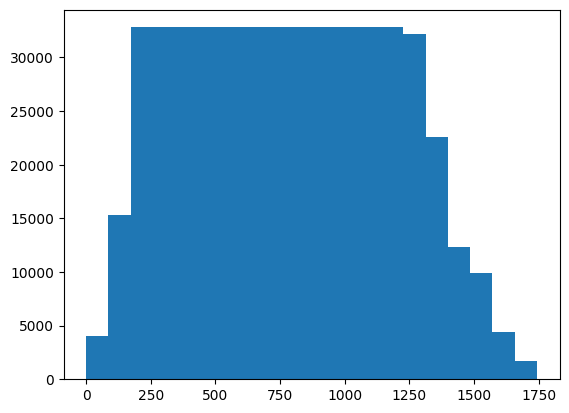

In [8]:
# Make a histogram raster cell values in a bounding box

params = {'bbox': bbox,
          'nbin': 9} # Omit 'nbin' parameter for default of 14
res = s.get(f'{api_url}/object/{raster_id}/histogram', params=params)
df = pd.json_normalize(res.json())
display(df)

# The dataframe returned is already formatted as a histogram, so we plot it as a bar chart
bar_width = df['max'].iloc[0] # Set bar width equal to bin size
plt.bar(df['max']-(bar_width/2), df['count'], width=bar_width)
plt.show()

### Section 3: View and download a subset of an individual raster

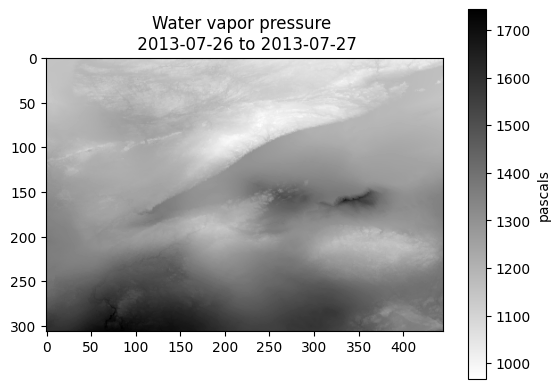

In [9]:
# Visualize the area of a raster within a bounding box

params = {'bbox': bbox}
res = s.get(f'{api_url}/object/{raster_id}/raster', params=params)

# Open the response as a memory file and plot it
with rasterio.MemoryFile(res.content) as memfile:
    with memfile.open() as dataset:
        data = dataset.read(1)
        palette = plt.cm.gray_r.copy()
        plt.imshow(data, cmap=palette)
        plt.title(f'{name} \n {t_start} to {t_end}')
        plt.colorbar(label=units)
    plt.show()

In [10]:
# Download a subset of the raster defined by a bounding box

params= {'bbox': bbox}

res = s.get(f'{api_url}/object/{raster_id}/raster', params=params)
out_path = 'raster_subset.tif' # Change to a local path

with rasterio.MemoryFile(res.content) as memfile:
    with memfile.open() as raster:
        with rasterio.open(out_path, 'w', **raster.profile) as dst:
            dst.write(raster.read(1), 1) # Read the first band (DEM data are single band) of the raster and write to first band of file

### Section 4: Create tabular time series data for an AOI

In [11]:
# Use the search function to pull all data for two variables between two dates.
# Then construct a dataframe.

var_list = ['Precipitation',
            'Water vapor pressure',
            'Maximum air temperature']

res = s.get(f'{api_url}/layer').json()
variables = pd.json_normalize(res)

start_date = '2013-07-20'
end_date = '2013-08-05'

columns = []
for var in var_list:
    var_id = variables.loc[variables['name'] == var, 'id'].iloc[0]

    params = {'layer': var_id,
              'begin': start_date,
              'end': end_date}

    rasters = s.get(f'{api_url}/object/search', params=params).json()

    raster_attributes = []
    for raster in rasters:
        raster_attributes.append({'time': raster['t_ranges'][0]['begin'], 'id': raster['id']})

    column = []
    for raster in raster_attributes:
        var_value = s.post(f'{api_url}/object/{raster["id"]}/stats', json=aoi).json()['mean']
        row = {'time': raster['time'], var: var_value}
        column.append(row)
    column = pd.DataFrame.from_dict(column).set_index('time')
    columns.append(column)

df = pd.concat(columns, axis=1, join='inner')
display(df)

,Precipitation,Water vapor pressure,Maximum air temperature
time,,,
2013-07-20,0.000000,1264.261152,20.170457
2013-07-21,0.740538,1027.134343,19.528690
2013-07-22,0.021253,1257.624831,26.901226
2013-07-23,0.000000,1274.540301,21.671655
2013-07-24,0.671538,1185.354675,22.262554
2013-07-25,7.618187,1389.670591,22.526518
2013-07-26,5.781097,1221.163743,15.166104
2013-07-27,4.145497,1003.346011,13.041616
2013-07-28,0.602854,1154.825908,20.072685
